# Hubble Ultra Deep Field (f105w)

### reusing the sep workflow on the udf f105w image and then grabbing basic flux stats and a fake 3 color image towards the end

In [21]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse

%matplotlib inline
rcParams["figure.figsize"] = [10., 8.]
import os
print("data contents:", os.listdir("../data"))


data contents: ['hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits', 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_wht.fits', 'hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits', 'hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_wht.fits', 'hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits', 'hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_wht.fits', 'image.fits']


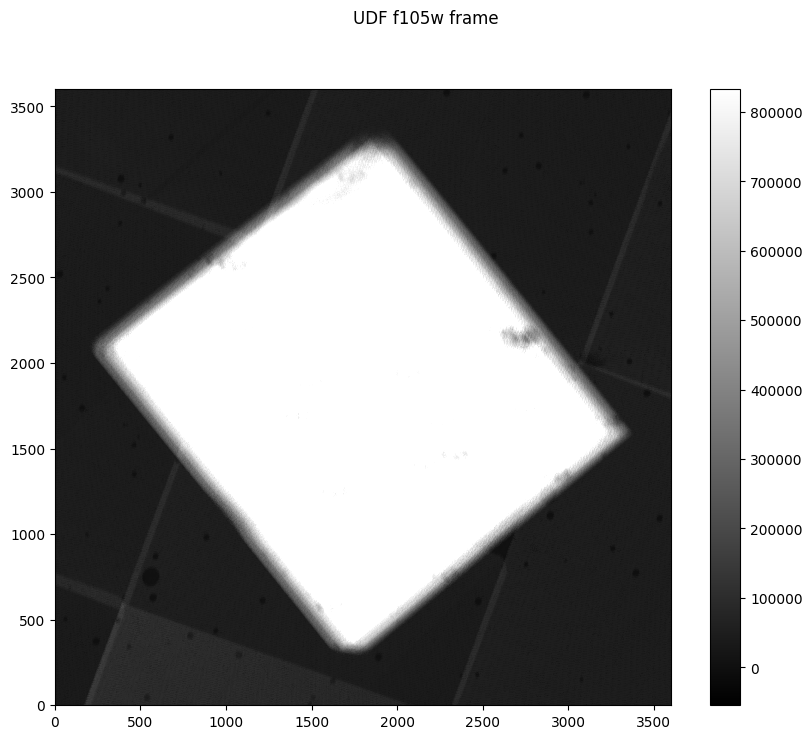

In [23]:
path = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_wht.fits"

img = fits.getdata(path)
img = img.astype(img.dtype.newbyteorder('='))

mid, spread = np.mean(img), np.std(img)

fig, ax = plt.subplots()
show = ax.imshow(
    img,
    interpolation = "nearest",
    cmap = "gray",
    vmin = mid - spread,
    vmax = mid + spread,
    origin = "lower",
)

fig.colorbar(show,ax=ax)
fig.suptitle("UDF f105w frame")
fig.savefig("../figs/udf105_img.png", dpi=150, bbox_inches="tight")
plt.show()
